# Datasets comparison between CAMS and TROPOMI (L2)

## Imports and supporting functions

In [26]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

In [59]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_tropomi.ipynb

In [28]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [29]:
# Define component (NO2, CO, O3, SO2 or HCHO)
component_nom = 'NO2'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Define sensor
sensor = 'tropomi'
sensor_type = 'L2'
apply_kernels = False

# Define search period
start_date = '2021-11-18'
end_date = '2021-11-18'

# Define extent
area_name = 'Barcelona'
lon_min = 1.5
lon_max = 2.5
lat_min = 41
lat_max = 42

In [30]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type, apply_kernels)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column, column_type = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [31]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In days: [('2021-11-18T00:00:00Z', '2021-11-18T23:00:00Z')]
SEARCH BOUNDING BOX
Latitudes: from 41 to 42
Longitudes: from 1.5 to 2.5


## 2. Model data

### Download and read data as xarray

In [32]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               lat_min, lat_max, lon_min, lon_max, area_name, model_full_name, 
                                               model_level = 'Multiple', CAMS_UID = None, CAMS_key = None)

The file exists, it will not be downloaded again.


In [33]:
model_ds, _, model_levels_df = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 3, longitude: 3, step: 8, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-18
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 41.0 41.4 41.8
  * longitude   (longitude) float64 1.5 1.9 2.3
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 3.873e-09 ....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-11T10:37 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [34]:
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],Depth [m]
hybrid,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2320.96
...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,22.96


### Convert CAMS data units (kg/kg to molecules/cm<sup>2</sup>)

In [35]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg kg**-1 to kg m**-2.
The model component units have been converted from kg m**-2 to molec cm-2.


### Get CAMS levels (total or tropospheric)

In [36]:
model_ds = CAMS_get_levels_data(model_ds, model_product_name, model_levels_df, 
                                column_type, lat_min, lat_max, lon_min, lon_max)
model_ds

2022-01-11 10:37:37,830 INFO Welcome to the CDS
2022-01-11 10:37:37,831 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts


The model tropospheric columns will be compared to the tropospheric sensor columns.
The model tropospheric columns will be estimated (pressures above or equal to 300 hPa).


2022-01-11 10:37:38,279 INFO Request is completed
2022-01-11 10:37:38,280 INFO Downloading https://download-0001.copernicus-atmosphere.eu/cache-compute-0001/cache/data0/adaptor.mars_constrained.external-1641809961.6149287-7135-16-fe54cc39-cdc8-4487-bf1a-247256a15b8f.grib to /home/alba/adc-toolbox/data/cams/NO2/CAMS_FORECAST_SURFACE_PRESSURE_2021-11-18_2021-11-18_Barcelona.grib (1008)
2022-01-11 10:37:38,349 INFO Download rate 14.4K/s
2022-01-11 10:37:38,361 WARNING Ignoring index file '/home/alba/adc-toolbox/data/cams/NO2/CAMS_FORECAST_SURFACE_PRESSURE_2021-11-18_2021-11-18_Barcelona.grib.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:     (latitude: 3, longitude: 3, step: 8, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-18
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * latitude    (latitude) float64 41.0 41.4 41.8
  * longitude   (longitude) float64 1.5 1.9 2.3
    valid_time  (step) datetime64[ns] 2021-11-18 ... 2021-11-18T21:00:00
Data variables:
    component   (time, step, latitude, longitude) float64 4.742e+15 ... 5.057...
    pressure    (time, step, latitude, longitude) float64 3.986e+06 ... 3.836...

### Download read and subset original total columns data

In [37]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               lat_min, lat_max, lon_min, lon_max, area_name, model_full_name, 
                                               model_level = 'Single', CAMS_UID = None, CAMS_key = None)

The file exists, it will not be downloaded again.


In [38]:
model_total_ds, _, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_total_ds

<xarray.Dataset>
Dimensions:     (latitude: 3, longitude: 3, step: 8, time: 1)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-11-18
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 ...
  * latitude    (latitude) float64 41.0 41.4 41.8
  * longitude   (longitude) float64 1.5 1.9 2.3
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 7.007e-06 ... 7.04e-06
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-11T10:37 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS total columns data units (kg/m2 to molecules/cm<sup>2</sup>)

In [39]:
model_total_ds, _ = model_convert_units(model, model_total_ds, sensor,
                                        component_mol_weight, model_levels_df,
                                        start_date, end_date, component_nom, apply_kernels,
                                        CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

### Download and read data as xarray

In [40]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, bbox, product_type)

RESULTS
For ('2021-11-18T00:00:00Z', '2021-11-18T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2022-01-11 10:37:40,371 INFO Found 0 products
2022-01-11 10:37:40,461 INFO Found 1 products


There are no results for the processing mode NRT. The search in the offline archives will start.
Number 0-S5P_OFFL_L2__NO2____20211118T112150_20211118T130320_21240_02_020301_20211120T033928
SELECTED
File name: c0858e18-3e8d-4885-8cf1-9c57236d07e7
Product name: S5P_OFFL_L2__NO2____20211118T112150_20211118T130320_21240_02_020301_20211120T033928.nc
The file exists, it will not be downloaded again.


In [41]:
sensor_ds, support_input_ds, support_details_ds = sensor_read(sensor, sensor_type, sensor_column, 
                                                              component_nom, dates)
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 4173, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

In [42]:
support_input_ds

<xarray.Dataset>
Dimensions:                                (ground_pixel: 450, scanline: 4173, time: 1)
Coordinates:
  * time                                   (time) datetime64[ns] 2021-11-18
  * scanline                               (scanline) float64 0.0 ... 4.172e+03
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
Data variables: (12/18)
    surface_altitude                       (time, scanline, ground_pixel) float32 ...
    surface_altitude_precision             (time, scanline, ground_pixel) float32 ...
    surface_classification                 (time, scanline, ground_pixel) float32 ...
    instrument_configuration_identifier    (time, scanline) float64 20.0 ... ...
    instrument_configuration_version       (time, scanline) float32 24.0 ... ...
    scaled_small_pixel_variance            (time, scanline, ground_pixel) float32 ...
    ...                                     ...
    cloud_fraction_crb                     (time, scanline, ground_pixel) float32 ...
    cloud_albedo_crb                       (time, scanline, ground_pixel) float32 ...
    scene_albedo                           (time, scanline, ground_pixel) float32 ...
    apparent_scene_pressure                (time, scanline, ground_pixel) float32 ...
    snow_ice_flag                          (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388                  (time, scanline, ground_pixel) float32 ...

In [43]:
support_details_ds

<xarray.Dataset>
Dimensions:                                                (ground_pixel: 450, intensity_offset_polynomial_exponents: 1, polynomial_exponents: 6, scanline: 4173, time: 1)
Coordinates:
  * time                                                   (time) datetime64[ns] ...
  * scanline                                               (scanline) float64 ...
  * ground_pixel                                           (ground_pixel) float64 ...
Dimensions without coordinates: intensity_offset_polynomial_exponents, polynomial_exponents
Data variables: (12/45)
    processing_quality_flags                               (time, scanline, ground_pixel) float64 ...
    number_of_spectral_points_in_retrieval                 (time, scanline, ground_pixel) float32 ...
    number_of_iterations                                   (time, scanline, ground_pixel) float64 ...
    wavelength_calibration_offset                          (time, scanline, ground_pixel) float32 ...
    wavelength_calibration_offset_precision                (time, scanline, ground_pixel) float32 ...
    wavelength_calibration_stretch                         (time, scanline, ground_pixel) float32 ...
    ...                                                     ...
    degrees_of_freedom                                     (time, scanline, ground_pixel) float32 ...
    air_mass_factor_stratosphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_cloudy                                 (time, scanline, ground_pixel) float32 ...
    air_mass_factor_clear                                  (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_ghost_column                           (time, scanline, ground_pixel) float32 ...
    cloud_selection_flag                                   (time, scanline, ground_pixel) float32 ...

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [44]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component_nom)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.


<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 4173, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float64 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

## 4. Match data (and apply averaging kernels)

In [45]:
match_df = generate_match_df(sensor_ds, model_ds, bbox, sensor, component_nom, sensor_type, apply_kernels)
match_df

FOR DATE: 2021-11-18
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.


layer              delta_time   latitude  \
scanline ground_pixel time                                                   
3294.0   104.0        2021-11-18    0.0 2021-11-18 12:29:32.250  40.749073   
         105.0        2021-11-18    0.0 2021-11-18 12:29:32.250  40.768257   
         106.0        2021-11-18    0.0 2021-11-18 12:29:32.250  40.787251   
         107.0        2021-11-18    0.0 2021-11-18 12:29:32.250  40.806057   
         108.0        2021-11-18    0.0 2021-11-18 12:29:32.250  40.824673   
...                                 ...                     ...        ...   
3317.0   122.0        2021-11-18    0.0 2021-11-18 12:29:51.570  42.173199   
         123.0        2021-11-18    0.0 2021-11-18 12:29:51.570  42.189560   
         124.0        2021-11-18    0.0 2021-11-18 12:29:51.570  42.205772   
         125.0        2021-11-18    0.0 2021-11-18 12:29:51.570  42.221844   
         126.0        2021-11-18    0.0 2021-11-18 12:29:51.570  42.237774   

                                  longitude  qa_value  sensor_column  \
scanline ground_pixel time                                             
3294.0   104.0        2021-11-18   1.652233      0.74   3.095303e+15   
         105.0        2021-11-18   1.709576      0.74   2.979195e+15   
         106.0        2021-11-18   1.766579      0.74   2.523980e+15   
         107.0        2021-11-18   1.823249      0.74   3.217050e+15   
         108.0        2021-11-18   1.879590      0.74   2.826590e+15   
...                                     ...       ...            ...   
3317.0   122.0        2021-11-18   2.157079      1.00   1.414198e+15   
         123.0        2021-11-18   2.209967      1.00   2.486753e+15   
         124.0        2021-11-18   2.262609      1.00   2.677387e+15   
         125.0        2021-11-18   2.315008      1.00   1.854234e+15   
         126.0        2021-11-18   2.367170      1.00   3.465692e+15   

                                  nitrogendioxide_tropospheric_column_precision  \
scanline ground_pixel time                                                        
3294.0   104.0        2021-11-18                                       0.000016   
         105.0        2021-11-18                                       0.000016   
         106.0        2021-11-18                                       0.000014   
         107.0        2021-11-18                                       0.000016   
         108.0        2021-11-18                                       0.000015   
...                                                                         ...   
3317.0   122.0        2021-11-18                                       0.000014   
         123.0        2021-11-18                                       0.000017   
         124.0        2021-11-18                                       0.000018   
         125.0        2021-11-18                                       0.000015   
         126.0        2021-11-18                                       0.000021   

                                  nitrogendioxide_tropospheric_column_precision_kernel  \
scanline ground_pixel time                                                               
3294.0   104.0        2021-11-18                                           0.000012      
         105.0        2021-11-18                                           0.000012      
         106.0        2021-11-18                                           0.000012      
         107.0        2021-11-18                                           0.000012      
         108.0        2021-11-18                                           0.000012      
...                                                                             ...      
3317.0   122.0        2021-11-18                                           0.000013      
         123.0        2021-11-18                                           0.000015      
         124.0        2021-11-18                                           0.000015      
         125

## 5. Merge data and calculate difference

In [46]:
merge_df = generate_merge_df(match_df, sensor_ds, model_ds, sensor, apply_kernels)
merge_df

latitude  longitude  model_column  \
scanline ground_pixel time                                             
3294.0   104.0        2021-11-18  40.749073   1.652233  1.748595e+15   
         105.0        2021-11-18  40.768257   1.709576  3.735788e+15   
         106.0        2021-11-18  40.787251   1.766579  3.735788e+15   
         107.0        2021-11-18  40.806057   1.823249  3.735788e+15   
         108.0        2021-11-18  40.824673   1.879590  3.735788e+15   
...                                     ...        ...           ...   
3317.0   122.0        2021-11-18  42.173199   2.157079  2.703672e+15   
         123.0        2021-11-18  42.189560   2.209967  2.703672e+15   
         124.0        2021-11-18  42.205772   2.262609  2.703672e+15   
         125.0        2021-11-18  42.221844   2.315008  2.703672e+15   
         126.0        2021-11-18  42.237774   2.367170  2.703672e+15   

                                  sensor_column    difference  \
scanline ground_pixel time                                      
3294.0   104.0        2021-11-18   3.095303e+15  1.346708e+15   
         105.0        2021-11-18   2.979195e+15 -7.565931e+14   
         106.0        2021-11-18   2.523980e+15 -1.211808e+15   
         107.0        2021-11-18   3.217050e+15 -5.187374e+14   
         108.0        2021-11-18   2.826590e+15 -9.091981e+14   
...                                         ...           ...   
3317.0   122.0        2021-11-18   1.414198e+15 -1.289474e+15   
         123.0        2021-11-18   2.486753e+15 -2.169191e+14   
         124.0        2021-11-18   2.677387e+15 -2.628549e+13   
         125.0        2021-11-18   1.854234e+15 -8.494383e+14   
         126.0        2021-11-18   3.465692e+15  7.620200e+14   

                                  relative_difference  
scanline ground_pixel time                             
3294.0   104.0        2021-11-18            -0.435081  
         105.0        2021-11-18             0.253959  
         106.0        2021-11-18             0.480118  
         107.0        2021-11-18             0.161246  
         108.0        2021-11-18             0.321659  
...                                               ...  
3317.0   122.0        2021-11-18             0.911806  
         123.0        2021-11-18             0.087230  
         124.0        2021-11-18             0.009818  
         125.0        2021-11-18             0.458107  
         126.0        2021-11-18            -0.219875  

[552 rows x 6 columns]

In [47]:
descr_stats_table = merge_df.describe()
descr_stats_table

,latitude,longitude,model_column,sensor_column,difference,relative_difference
count,552.000000,552.000000,5.520000e+02,5.520000e+02,5.520000e+02,552.000000
mean,41.498760,2.017442,3.499030e+15,4.650236e+15,1.151206e+15,-0.221362
std,0.352288,0.390623,2.275313e+15,1.951500e+15,2.329901e+15,0.484854
min,40.749073,1.157278,1.179948e+15,1.414198e+15,-5.181994e+15,-0.820765
25%,41.211368,1.706943,1.481793e+15,3.466707e+15,-3.396365e+14,-0.616481
50%,41.499559,2.024176,2.703672e+15,4.261100e+15,1.491336e+15,-0.370169
75%,41.787479,2.332140,6.180766e+15,5.323355e+15,2.594129e+15,0.087266
max,42.237774,2.843995,7.439206e+15,1.765394e+16,1.021473e+16,2.295749


## 6. Show comparison plots

### Select plot dates

In [48]:
plot_dates = plot_period(sensor_ds, sensor_type)

The plots will be shown for the following dates:
['2021-11-18']


### Select plot extent

In [49]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((1.5, 41), (2.5, 42))


### Compare CAMS and TROPOMI total columns

Frame length between 1.5 and 2.5 should be one of these options: [0.1, 0.2, 0.5, 1.0]
Frame length between 41 and 42 should be one of these options: [0.1, 0.2, 0.5, 1.0]


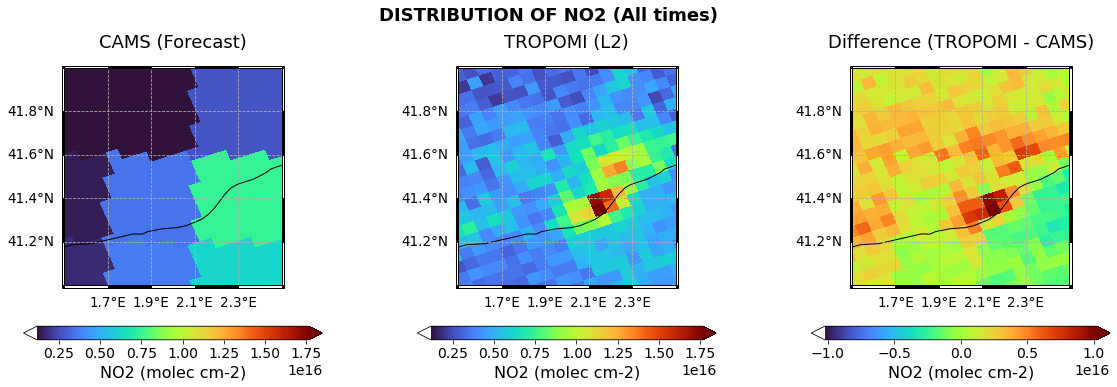

In [62]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'aggregated'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'turbo' 

# Get and decide the best width and height of the B/W frame lines
options_height_lon = get_frame_possible_lengths(lon_min, lon_max)
options_width_lat = get_frame_possible_lengths(lat_min, lat_max)
width_lon = 0.2
height_lat = 0.2

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 1.05, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, width_lon, height_lat, vmin_manual, vmax_manual)

### Compare CAMS original and averaged total columns

Frame length between 1.5 and 2.5 should be one of these options: [0.1, 0.2, 0.5, 1.0]
Frame length between 41 and 42 should be one of these options: [0.1, 0.2, 0.5, 1.0]


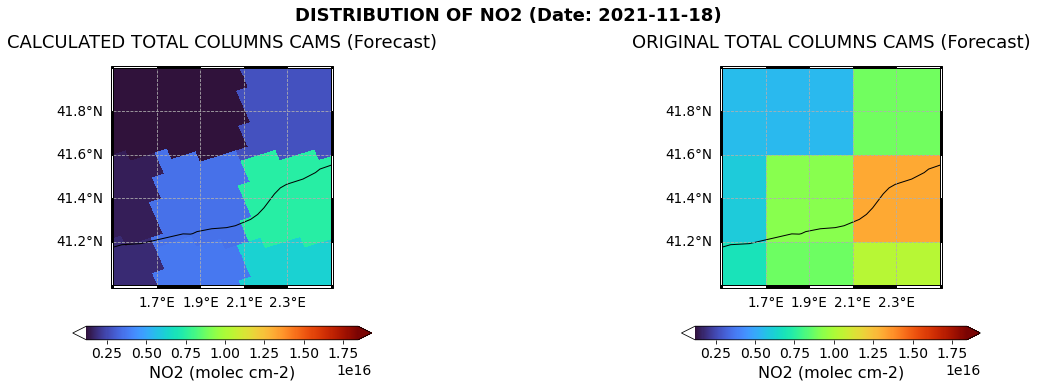

In [63]:
# Choose distribution (individual)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal' # original or equal
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'turbo' 

# Get and decide the best width and height of the B/W frame lines
options_height_lon = get_frame_possible_lengths(lon_min, lon_max)
options_width_lat = get_frame_possible_lengths(lat_min, lat_max)
width_lon = 0.2
height_lat = 0.2


visualize_model_original_vs_calculated(model, component_nom,units, merge_df, model_total_ds, plot_dates, 
                                       plot_bbox, 20, 1.05, model_type, range_type, projection, color_scale,
                                       width_lon, height_lat, vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific coordinates

In [64]:
coords_search_list = (41.39, 2.15,
                      41.1, 1.65)
ymin = 0
ymax = 5*10**15
xticks = plot_dates
timeseries_table = timeseries(merge_df.dropna(), coords_search_list, component_nom, 
                              sensor, sensor_type, model, plot_dates, units, ymin, ymax, xticks)
timeseries_table

,,,,,scanline,ground_pixel,model_column,sensor_column,difference,relative_difference
lat_search,lon_search,latitude,longitude,time,,,,,,
41.39,2.15,41.399746,2.131355,2021-11-18,3303.0,116.0,7.439206e+15,1.711462e+16,9.675409e+15,-0.565330
41.10,1.65,41.075066,1.639530,2021-11-18,3300.0,106.0,1.748595e+15,3.974105e+15,2.225511e+15,-0.560003


## 8. Scatter plots by bbox

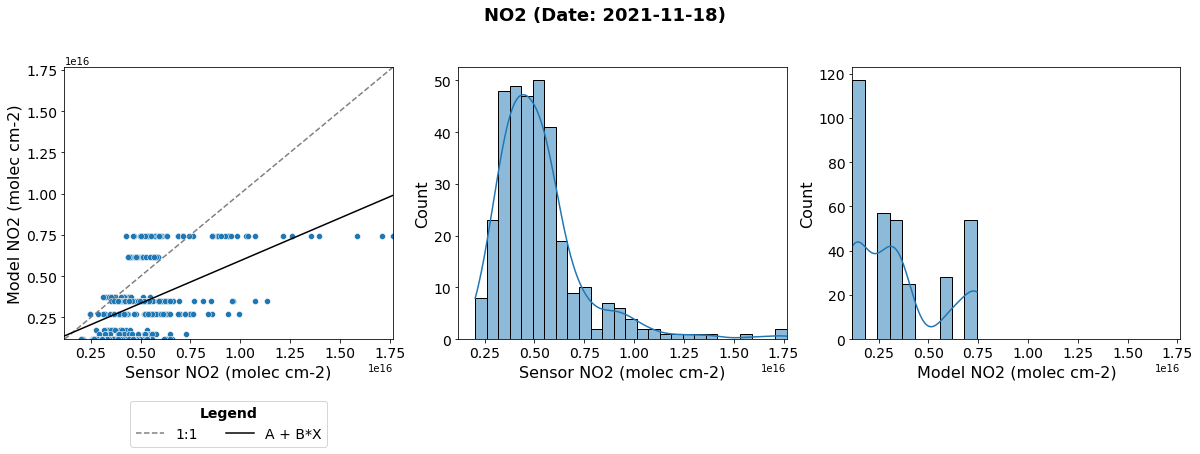

,Period,Location,A,B,R2,RMSE,MSE
0,2021-11-18,"((1.5, 41), (2.5, 42))",0.516815,7.701377e+14,0.266477,1.895189e+15,3.591743e+30


In [65]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)
summary

## 9. Scatter plots by season

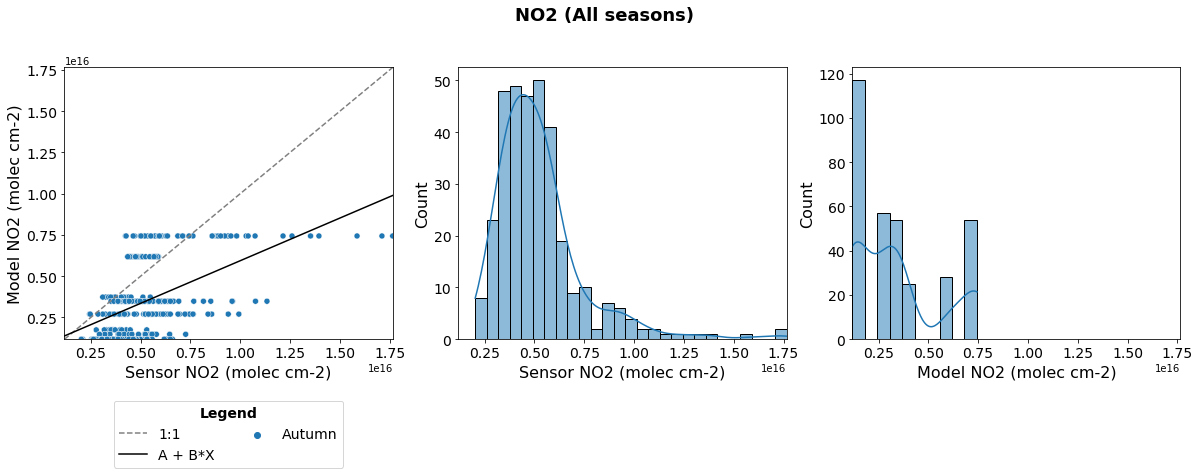

,Period,Location,A,B,R2,RMSE,MSE
0,[Autumn],"((1.5, 41), (2.5, 42))",0.516815,7.701377e+14,0.266477,1.895189e+15,3.591743e+30


In [66]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)
summary

## 10. Scatter plots by country (Google API required!)

In [67]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
plot_countries = ['Czech Republic', 'Poland', 'Germany']

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
summary
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'aggregated' # aggregated or individual\nplot_countries = ['Czech Republic', 'Poland', 'Germany']\n\nlim_min = None\nlim_max = None\n\nsummary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1.05, \n                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\nsummary\n"